# Stable Diffusion: How to run inference on the endpoint you have created?

Importing relevant packages for querying endpoint and image visualization

In [2]:
import boto3
import matplotlib.pyplot as plt
import numpy as np
import json

Helpers for endpoint querying and parsing results

In [3]:
endpoint_name = 'jumpstart-dft-stable-diffusion-v2-1-base'
def query_endpoint(text):
    client = boto3.client('runtime.sagemaker')
    
    encoded_text = text.encode("utf-8")
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/x-text', Body=encoded_text, Accept='application/json')
    
    return response

def parse_response(query_response):
    response_dict = json.loads(query_response['Body'].read())
    return response_dict['generated_image'], response_dict['prompt']

def display_image(img, prmpt):
    plt.figure(figsize=(12,12))
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.title(prmpt)
    plt.show()


### Query Stable Diffusion endpoint

***
Call model to generate image from prompt
***

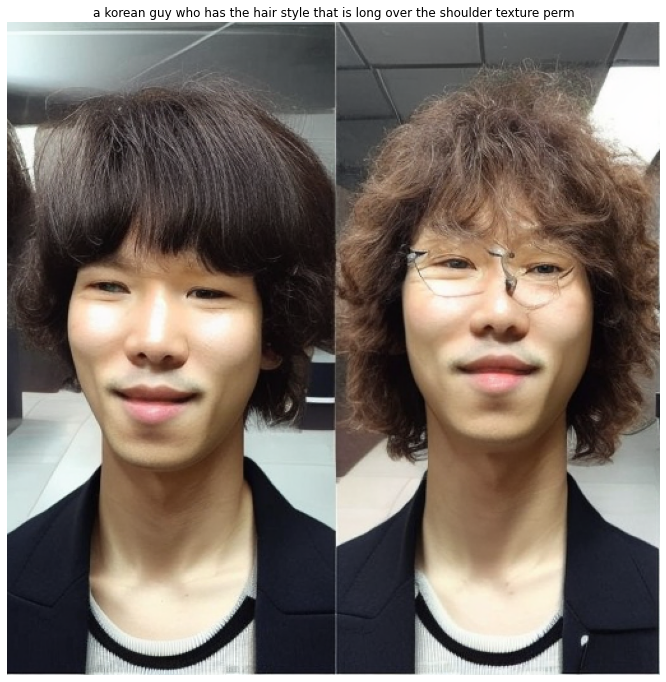

In [4]:
response = query_endpoint("a korean guy who has the hair style that is long over the shoulder texture perm")

img, prmpt = parse_response(response)

# Display hallucinated image
display_image(img,prmpt)

### Advanced features

***
This model also supports many advanced parameters while performing inference. They include:

* **prompt**: prompt to guide the image generation. Must be specified and can be a string or a list of strings.
* **width**: width of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **height**: height of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **num_inference_steps**: number of denoising steps during image generation. More steps lead to higher quality image. If specified, it must a positive integer.
* **guidance_scale**: higher guidance scale results in image closely related to the prompt, at the expense of image quality. If specified, it must be a float. guidance_scale<=1 is ignored.
* **negative_prompt**: guide image generation against this prompt. If specified, it must be a string or a list of strings and used with guidance_scale. If guidance_scale is disabled, this is also disabled. Moreover, if prompt is a list of strings then negative_prompt must also be a list of strings. 
* **num_images_per_prompt**: number of images returned per prompt. If specified it must be a positive integer. Generating multiple images may cause memory issues. Thus, we recommend reducing low height and width if setting num_images_per_prompt>1.
* **seed**: fix the randomized state for reproducibility. If specified, it must be an integer.

***

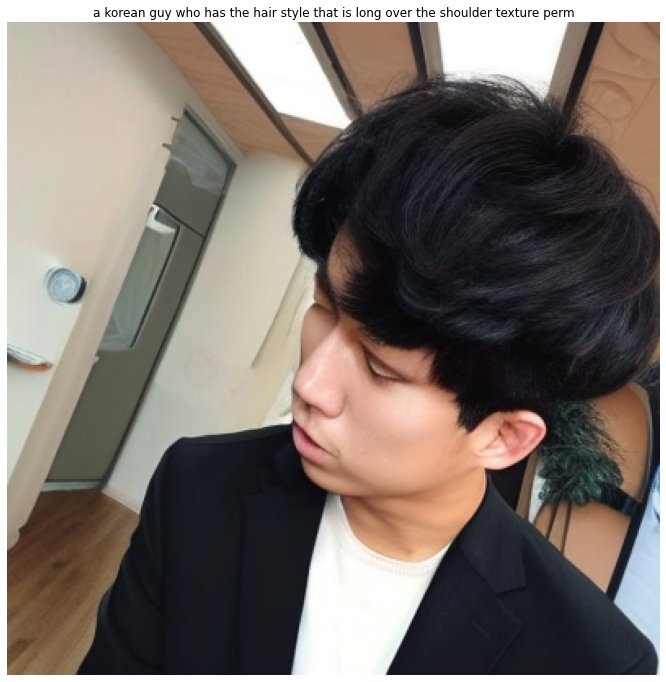

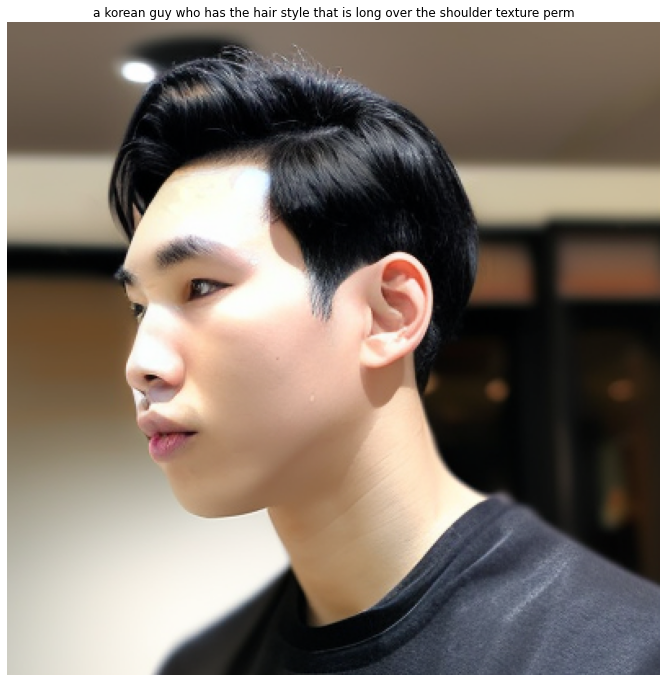

In [6]:
import json
payload = { "prompt":"a korean guy who has the hair style that is long over the shoulder texture perm", "width":400, "height":400,
           "num_images_per_prompt":2, "num_inference_steps":50, "guidance_scale":7.5}


def query_endpoint_with_json_payload(encoded_json):
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json', Body=encoded_json)
    return response

def parse_response_multiple_images(query_response):
    response_dict = json.loads(query_response['Body'].read())
    return response_dict['generated_images'], response_dict['prompt']

query_response = query_endpoint_with_json_payload(json.dumps(payload).encode('utf-8'))
generated_images, prompt = parse_response_multiple_images(query_response)
for img in generated_images:
    display_image(img, prompt)

### Compressed Image Output

---

Default response type above from an endpoint is a nested array with RGB values and if the generated image size is large, this may hit response size limit. To address this, we also support endpoint response where each image is returned as a JPEG image returned as bytes. To do this, please set `Accept = 'application/json;jpeg'`.


---

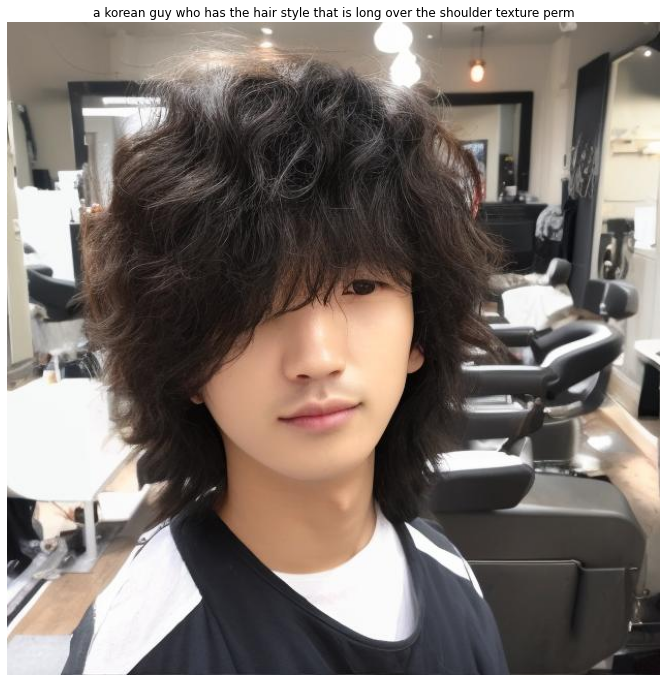

In [7]:
from PIL import Image
from io import BytesIO
import base64

#input_data = Image.open(BytesIO(input_data)).convert("RGB")
import json
payload = {"prompt":"a korean guy who has the hair style that is long over the shoulder texture perm", "width":632, "height":632}


client = boto3.client('runtime.sagemaker')

query_response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json', Body=json.dumps(payload).encode('utf-8'), Accept = 'application/json;jpeg')


generated_images, prompt = parse_response_multiple_images(query_response)

# generated_images are a list of jpeg images as bytes with b64 encoding.
# Next, we decode the images and convert to RGB format before displaying

for generated_image in generated_images:
    generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
    generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
    display_image(generated_image_rgb, prompt)